In [63]:
import torch
import gpytorch
from matplotlib import pyplot as plt
from gpytorch.likelihoods import GaussianLikelihood
import pandas as pd

import numpy as np
import os
import uproot

%matplotlib inline
%load_ext autoreload 
%autoreload 2

weights: torch.Size([1, 1])
X: torch.Size([30, 1])
X: tensor([[0.5131],
        [0.8579],
        [0.5832],
        [0.1589],
        [0.0000],
        [0.9259],
        [0.2316],
        [0.9492],
        [0.5611],
        [0.7297],
        [0.8896],
        [0.7635],
        [0.1274],
        [0.6906],
        [0.9612],
        [0.5784],
        [0.8320],
        [0.1003],
        [0.7800],
        [0.6433],
        [0.9363],
        [0.0490],
        [1.0000],
        [0.5558],
        [0.4267],
        [0.5119],
        [0.7644],
        [0.6638],
        [0.7182],
        [0.1702]])
weights: Parameter containing:
tensor([[0.1000]], requires_grad=True)
weights: torch.Size([1, 1])
X: torch.Size([30, 1])
X: tensor([[0.5131],
        [0.8579],
        [0.5832],
        [0.1589],
        [0.0000],
        [0.9259],
        [0.2316],
        [0.9492],
        [0.5611],
        [0.7297],
        [0.8896],
        [0.7635],
        [0.1274],
        [0.6906],
        [0.9612],
        [0.

In [32]:
final_df = pd.read_csv("M_2_fixed.csv")

In [33]:
M_1 = final_df['IN_M_1']
Omega = final_df['MO_Omega']

# Filter Omega, M_1, and M_2 
mask = (Omega > 0) 

# Apply the mask to filter M_1, M_2, and Omega
M_1_filtered = M_1[mask]
Omega_filtered = Omega[mask]

n_points = 50
n_train = 30
n_test = 100000

# Limit to only 100 points
M_1_limited = M_1_filtered.iloc[:n_points]
Omega_limited = Omega_filtered.iloc[:n_points]

# Convert to train
x_train = torch.tensor(M_1_limited.values[:n_train], dtype=torch.float32)
y_train = torch.log(torch.tensor(Omega_limited.values[:n_train], dtype=torch.float32)/0.12)


# Convert to valid
x_valid = torch.tensor(M_1_limited.values[n_train:], dtype=torch.float32)
y_valid = torch.log(torch.tensor(Omega_limited.values[n_train:], dtype=torch.float32)/0.12)

Time to initialize model: 0.0011565685272216797 seconds
Time to load data: 0.09649181365966797 seconds
Time to initialize model: 0.002267599105834961 seconds
Time to load model: 0.002148151397705078 seconds


In [52]:
# Normalisierung der Daten auf min = 0 und maximum = 1
# Min-Max-Normalisierung für x_train
x_train_min = x_train.min(dim=0, keepdim=True).values
x_train_max = x_train.max(dim=0, keepdim=True).values
x_train = (x_train - x_train_min) / (x_train_max - x_train_min)

# Min-Max-Normalisierung für x_valid
x_valid_min = x_valid.min(dim=0, keepdim=True).values
x_valid_max = x_valid.max(dim=0, keepdim=True).values
x_valid = (x_valid - x_valid_min) / (x_valid_max - x_valid_min)

In [53]:
from multitaskGP import MultitaskGP


likelihood = GaussianLikelihood()
multitask_gp = MultitaskGP(x_train, y_train, x_valid, y_valid, likelihood)


Keys in the checkpoint dictioniary
model_state_dict
likelihood_state_dict
best_model_state_dict
losses
losses_valid

Model state_dict:
likelihood.noise_covar.raw_noise: torch.Size([1])
likelihood.noise_covar.raw_noise_constraint.lower_bound: torch.Size([])
likelihood.noise_covar.raw_noise_constraint.upper_bound: torch.Size([])
mean_module.weights: torch.Size([1, 1])
mean_module.bias: torch.Size([1])
covar_module.raw_lengthscale: torch.Size([1, 1])
covar_module.raw_lengthscale_constraint.lower_bound: torch.Size([])
covar_module.raw_lengthscale_constraint.upper_bound: torch.Size([])
task_covar_module.covar_factor: torch.Size([1, 1])
task_covar_module.raw_var: torch.Size([1])
task_covar_module.IndexKernelPrior.a: torch.Size([1])
task_covar_module.IndexKernelPrior.b: torch.Size([1])
task_covar_module.IndexKernelPrior.sigma: torch.Size([1])
task_covar_module.IndexKernelPrior.tails.loc: torch.Size([1])
task_covar_module.IndexKernelPrior.tails.scale: torch.Size([1])
task_covar_module.raw_var_

In [54]:
# Load the saved model
multitask_gp.load_state_dict(torch.load('multitask_gp_state_dict.pth'))

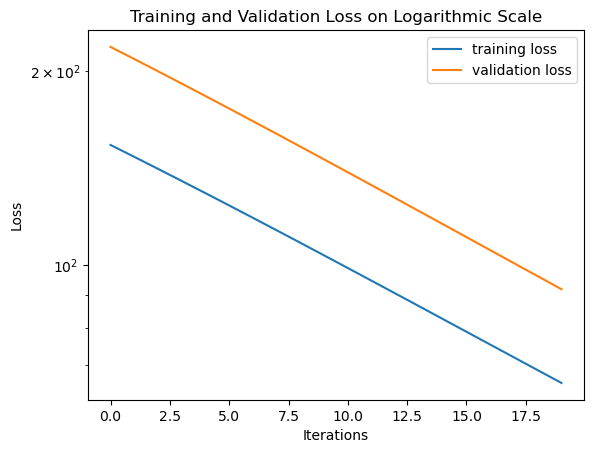

In [57]:
# Erstellen des Plots
plt.plot(losses, label='training loss')
plt.plot(losses_valid, label='validation loss')

# Setzen der y-Achse auf logarithmische Skala
plt.yscale('log')

# Hinzufügen der Legende
plt.legend()

# Achsenbeschriftungen und Titel hinzufügen (optional)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Loss on Logarithmic Scale')

# Anzeigen des Plots
plt.show()

In [58]:
x_test = torch.linspace(0, 1, 1000)

In [59]:
# from PublishGP.utils import entropy_local
from entropy import entropy_local 

def evaluate(multitask_gp, likelihood, x_test):
    """Evaluate GP on test sample and calculate corresponding entropies."""

    multitask_gp.eval()
    likelihood.eval()

    with torch.no_grad():
        # Get prediction:
        observed_pred = likelihood(multitask_gp(x_test))

        # Get upper and lower confidence bounds
        mean = observed_pred.mean.detach().reshape(-1, 1)
        device = "cuda" if torch.cuda.is_available() else "cpu"
        dtype = torch.float32
        var = observed_pred.variance.detach().reshape(-1, 1)
        thr = torch.Tensor([0.]) # Threshold in CDF calculation. Needs to be more sophisticated if params are scaled.

        entropy = entropy_local(mean, var, thr, device, dtype)
        
    return observed_pred, entropy

observed_pred, entropy = evaluate(multitask_gp, likelihood, x_test)

print("Observed prediction: ", observed_pred)

weights: torch.Size([1, 1])
X: torch.Size([1030, 1])
X: tensor([[0.5131],
        [0.8579],
        [0.5832],
        ...,
        [0.9980],
        [0.9990],
        [1.0000]])
weights: Parameter containing:
tensor([[0.2975]], requires_grad=True)
Observed prediction:  MultivariateNormal(loc: torch.Size([1000]))


In [60]:
# Convert to train
x_true = torch.tensor(M_1.values[:], dtype=torch.float32)

# Normalisierung der Daten auf min = 0 und maximum = 1
# Min-Max-Normalisierung für x_train
x_true_min = x_true.min(dim=0, keepdim=True).values
x_true_max = x_true.max(dim=0, keepdim=True).values
x_true = (x_true - x_true_min) / (x_true_max - x_true_min)

y_true = torch.log(torch.tensor(Omega.values[:], dtype=torch.float32)/0.12)

/tmp/ipykernel_128893/69488793.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  ax.plot(x_train.numpy(), y_train.numpy(), 'k*', c="b", label='Training Data')


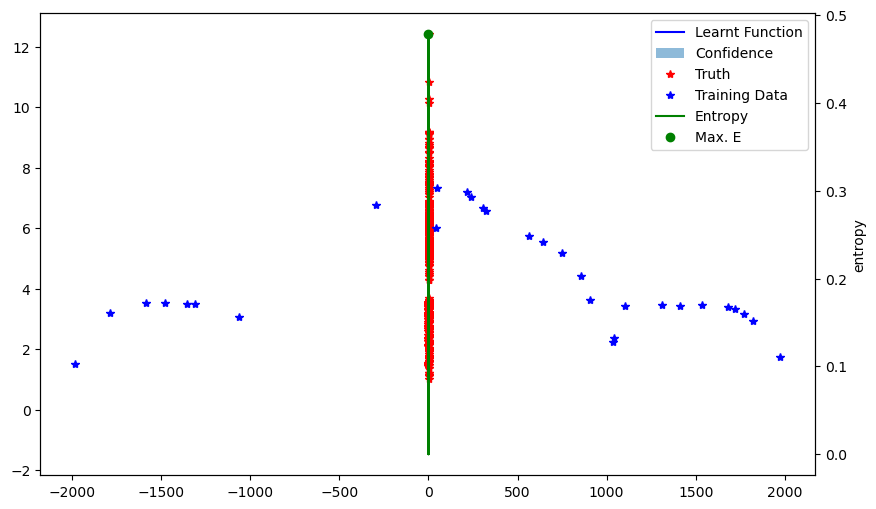

In [61]:
def plotGP(new_x = None):
    """Plot GP inclusive entropy"""

    mean = observed_pred.mean.numpy()
    lower, upper = observed_pred.confidence_region()

    # Initialize plot
    _, ax = plt.subplots(1, 1, figsize=(10, 6))

    
    # Plot predictive means as blue line
    ax.plot(x_test.numpy(), mean, 'b', label='Learnt Function')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(x_test.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label='Confidence')
    # ax.set_ylim([-3, 3])
    ax.plot(x_true, y_true, '*', c="r", label='Truth')
    # Plot training data as black stars
    ax.plot(x_train.numpy(), y_train.numpy(), 'k*', c="b", label='Training Data')

    # Add new points to be evaluated:
    if new_x is not None:
        dolabel = True
        for xval in new_x:
            ax.axvline(x=xval, color='r', linestyle='--', label='new points') if dolabel else ax.axvline(x=xval, color='r', linestyle='--')
            dolabel = False

    ax2 = ax.twinx()
    ax2.set_ylabel("entropy")
    ax2.plot(x_test, entropy, 'g', label='Entropy')

    maxE = torch.max(entropy)
    maxIndex = torch.argmax(entropy)
    maxX = x_test[maxIndex]
    ax2.plot(maxX, maxE, 'go', label='Max. E')

    # add common legend:
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2)

plotGP()